In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import cudaq
from cudaq import spin

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.Resize((32, 32))])
batch_size = 1
trainset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)

cat_idx = trainset.class_to_idx['airplane']
ship_idx = trainset.class_to_idx['automobile']

n_cat = 500
cat_filtered_indices = []
for i, (_, label) in enumerate(trainset):
    if len(cat_filtered_indices) == n_cat:
        break
    if label == cat_idx:
        cat_filtered_indices.append(i)

n_ship = 500
ship_filtered_indices = []
for i, (_, label) in enumerate(trainset):
    if len(ship_filtered_indices) == n_ship:
        break
    if label == ship_idx:
        ship_filtered_indices.append(i)

filtered_indices = cat_filtered_indices + ship_filtered_indices
print(len(filtered_indices))
new_trainset = torch.utils.data.Subset(trainset, filtered_indices)

trainloader = torch.utils.data.DataLoader(new_trainset, batch_size=batch_size, shuffle=True, num_workers=2)

Files already downloaded and verified
1000


In [3]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

n_cat = 100
cat_filtered_indices = []
for i, (_, label) in enumerate(testset):
    if len(cat_filtered_indices) == n_cat:
        break
    if label == cat_idx:
        cat_filtered_indices.append(i)

n_ship = 100
ship_filtered_indices = []
for i, (_, label) in enumerate(testset):
    if len(ship_filtered_indices) == n_ship:
        break
    if label == ship_idx:
        ship_filtered_indices.append(i)

filtered_indices = cat_filtered_indices + ship_filtered_indices
print(len(filtered_indices))
new_testset = torch.utils.data.Subset(testset, filtered_indices)

testloader = torch.utils.data.DataLoader(new_testset, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
200


In [4]:
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

tensor([0])


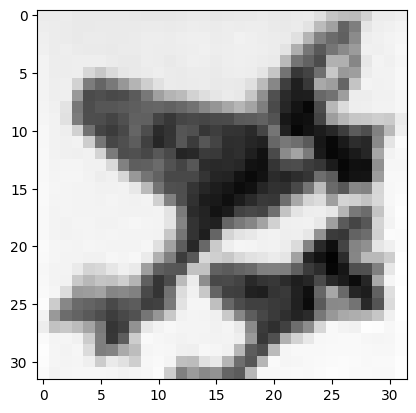

airplane


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(labels)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [6]:
#8Qx2
class QuantumCircuit:
    """This class defines the quantum circuit structure and the run method which is used to calculate an expectation value"""

    def __init__(self, qubit_count: int):
        """Define the quantum circuit in CUDA Quantum"""

        kernel, thetas = cudaq.make_kernel(list)

        self.kernel = kernel

        self.theta = thetas

        qubits = kernel.qalloc(qubit_count)

        self.kernel.h(qubits)

        # Variational gate parameters which are optimised during training
        for i in range(qubit_count):
            kernel.rx(thetas[2*i], qubits[i])
            if i != qubit_count - 1:
                kernel.crx(thetas[2*i + 1], qubits[i], qubits[i+1])
            else:
                kernel.crx(thetas[2*i + 1], qubits[i], qubits[0])

        hamiltonian = spin.z(0)
        for i in range(1, qubit_count):
            hamiltonian *= spin.z(i)
        # print(hamiltonian)
        self.hamiltonian = hamiltonian

    def run(self, thetas: torch.tensor) -> torch.tensor:
        """Excetute the quantum circuit to output an expectation value"""
        expectation = torch.tensor(cudaq.observe(self.kernel, self.hamiltonian,
                                                 thetas).expectation(),
                                   device=device)

        return expectation
class QuantumFunction(Function):
    """Allows the quantum circuit to pass data through it and compute the gradients"""

    @staticmethod
    def forward(ctx, thetas: torch.tensor, quantum_circuit,
                shift) -> torch.tensor:
        # Save shift and quantum_circuit in context to use in backward
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        # Calculate exp_val
        expectation_z = ctx.quantum_circuit.run(thetas)

        ctx.save_for_backward(thetas, expectation_z)
        #print(expectation_z)
        return expectation_z

    @staticmethod
    def backward(ctx, grad_output):
        """Backward pass computation via finite difference parameter shift"""

        thetas, expectation_z = ctx.saved_tensors

        gradients = torch.zeros(len(thetas), device=device)

        for i in range(len(thetas)):
            shift_right = torch.clone(thetas)

            shift_right[i] += ctx.shift

            shift_left = torch.clone(thetas)

            shift_left[i] -= ctx.shift

            expectation_right = ctx.quantum_circuit.run(shift_right)
            expectation_left = ctx.quantum_circuit.run(shift_left)

            gradients[i] = 0.5 * (expectation_right - expectation_left)

        return gradients * grad_output.float(), None, None

In [7]:
class QuantumLayer(nn.Module):
    """Encapsulates a quantum circuit and a quantum function into a quantum layer"""

    def __init__(self, shift: torch.tensor):
        super(QuantumLayer, self).__init__()
        self.quantum_circuit = QuantumCircuit(8)
        self.shift = shift

    def forward(self, input):
        ans = QuantumFunction.apply(input, self.quantum_circuit, self.shift)
        return ans

In [8]:
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda")

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 16)
        self.hybrid = QuantumLayer(
            torch.tensor(np.pi / 2)
        )

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x)).reshape(-1)
        x = self.hybrid(x).reshape(-1)
        return torch.cat((x, 1 - x), -1).unsqueeze(0)


net = Net().to(device)

In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [10]:
st_time = time.time()
for epoch in range(9):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 400 == 399:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 400:.3f}')
            running_loss = 0.0
ed_time = time.time()
print('Finished Training')
print('time taken: ', ed_time - st_time)

[1,   400] loss: 0.790
[1,   800] loss: 0.816
[2,   400] loss: 0.630
[2,   800] loss: 0.578
[3,   400] loss: 0.532
[3,   800] loss: 0.533
[4,   400] loss: 0.518
[4,   800] loss: 0.468
[5,   400] loss: 0.472
[5,   800] loss: 0.469
[6,   400] loss: 0.450
[6,   800] loss: 0.467
[7,   400] loss: 0.453
[7,   800] loss: 0.439
[8,   400] loss: 0.439
[8,   800] loss: 0.428
[9,   400] loss: 0.441
[9,   800] loss: 0.427
Finished Training
time taken:  344.5898480415344


In [11]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 86 %
